In [1]:
import numpy as np
import pandas as pd

# Load Data

In [2]:
movies = pd.read_csv('data/movies.csv')
genome_scores = pd.read_csv('data/genome-scores.csv')
tags = pd.read_csv('data/tags.csv')
genome_tags = pd.read_csv('data/genome-tags.csv')
ratings = pd.read_csv('data/ratings.csv')

In [3]:
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [4]:
movies.shape

(9742, 3)

In [5]:
len(movies['movieId'].unique())

9742

In [6]:
movies['genres'] = movies['genres'].str.replace('|', ' ')

In [7]:
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure Animation Children Comedy Fantasy
1,2,Jumanji (1995),Adventure Children Fantasy
2,3,Grumpier Old Men (1995),Comedy Romance
3,4,Waiting to Exhale (1995),Comedy Drama Romance
4,5,Father of the Bride Part II (1995),Comedy


In [8]:
genome_scores.head()

,movieId,tagId,relevance
0,1,1,0.02900
1,1,2,0.02375
2,1,3,0.05425
3,1,4,0.06875
4,1,5,0.16000


In [9]:
genome_scores.shape

(14862528, 3)

In [10]:
tags.head()

,userId,movieId,tag,timestamp
0,2,60756,funny,1445714994
1,2,60756,Highly quotable,1445714996
2,2,60756,will ferrell,1445714992
3,2,89774,Boxing story,1445715207
4,2,89774,MMA,1445715200


In [11]:
tags.shape

(3683, 4)

In [12]:
len(tags['movieId'].unique())

1572

In [13]:
genome_tags.head()

,tagId,tag
0,1,007
1,2,007 (series)
2,3,18th century
3,4,1920s
4,5,1930s


In [14]:
genome_tags.shape

(1128, 2)

In [15]:
ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [16]:
ratings.shape

(100836, 4)

In [17]:
len(ratings['movieId'].unique())

9724

# Filtering and Cleaning

In [21]:
ratings_f = ratings.groupby('userId').filter(lambda x: len(x) >= 55)

In [22]:
len(ratings_f['movieId'].unique()) / len(movies['movieId'].unique()) * 100

98.7990145760624

In [23]:
len(ratings_f['userId'].unique()) / len(ratings['userId'].unique()) * 100

59.67213114754099

In [24]:
movie_list_rating = ratings_f.movieId.unique().tolist()

In [25]:
movies = movies[movies['movieId'].isin(movie_list_rating)]

In [26]:
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure Animation Children Comedy Fantasy
1,2,Jumanji (1995),Adventure Children Fantasy
2,3,Grumpier Old Men (1995),Comedy Romance
3,4,Waiting to Exhale (1995),Comedy Drama Romance
4,5,Father of the Bride Part II (1995),Comedy


In [27]:
movies.shape

(9625, 3)

In [28]:
Mapping_file = dict(zip(movies['title'].tolist(), movies['movieId'].tolist()))

In [29]:
tags.drop(['timestamp'], axis = 1, inplace = True)
ratings_f.drop(['timestamp'], axis = 1, inplace = True)

# Merge the movies and tags Data Frames

In [30]:
mixed = pd.merge(movies, tags, on = 'movieId', how = 'left')
mixed.head()

,movieId,title,genres,userId,tag
0,1,Toy Story (1995),Adventure Animation Children Comedy Fantasy,336.0,pixar
1,1,Toy Story (1995),Adventure Animation Children Comedy Fantasy,474.0,pixar
2,1,Toy Story (1995),Adventure Animation Children Comedy Fantasy,567.0,fun
3,2,Jumanji (1995),Adventure Children Fantasy,62.0,fantasy
4,2,Jumanji (1995),Adventure Children Fantasy,62.0,magic board game


# Create Metadata from genres and tag Columns

In [31]:
mixed.fillna("", inplace = True)
mixed = pd.DataFrame(mixed.groupby('movieId')['tag'].apply(lambda x: "%s" % ' '.join(x)))
Final = pd.merge(movies, mixed, on = 'movieId', how = 'left')
Final['metadata'] = Final[['tag', 'genres']].apply(lambda x: ' '.join(x), axis = 1)
Final[['movieId','title','metadata']].head()

,movieId,title,metadata
0,1,Toy Story (1995),pixar pixar fun Adventure Animation Children C...
1,2,Jumanji (1995),fantasy magic board game Robin Williams game A...
2,3,Grumpier Old Men (1995),moldy old Comedy Romance
3,4,Waiting to Exhale (1995),Comedy Drama Romance
4,5,Father of the Bride Part II (1995),pregnancy remake Comedy


# Creating a content latent matrix from movie metadata:

In [32]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [33]:
tfidf = TfidfVectorizer(stop_words = 'english')
tfidf_matrix = tfidf.fit_transform(Final['metadata'])
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), index = Final.index.tolist())
print(tfidf_df.shape)

(9625, 1675)


In [34]:
from sklearn.decomposition import TruncatedSVD

In [57]:
svd = TruncatedSVD(n_components = 200)
latent_matrix = svd.fit_transform(tfidf_df)

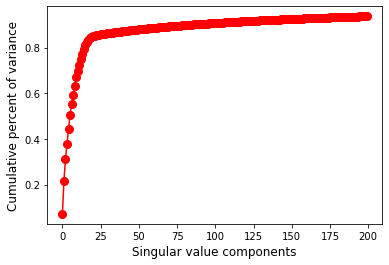

In [58]:
import matplotlib.pyplot as plt
explained = svd.explained_variance_ratio_.cumsum()
plt.plot(explained, '.-', ms = 16, color ='red')
plt.xlabel('Singular value components', fontsize = 12)
plt.ylabel('Cumulative percent of variance', fontsize = 12)        
plt.show()

In [59]:
n = 200
latent_matrix_1_df = pd.DataFrame(latent_matrix[:,0:n], index=Final.title.tolist())
latent_matrix_1_df.shape

(9625, 200)

# Creating a collaborative latent matrix from user ratings:

In [56]:
ratings_f.head()

,userId,movieId,rating
0,1,1,4.0
1,1,3,4.0
2,1,6,4.0
3,1,47,5.0
4,1,50,5.0


In [39]:
ratings_f1 = pd.merge(movies[['movieId']], ratings_f, on = "movieId", how = "right")

In [40]:
ratings_f2 = ratings_f1.pivot(index = 'movieId', columns = 'userId', values = 'rating').fillna(0)
ratings_f2.head()

userId,1,4,6,7,10,11,15,16,17,18,...,600,601,602,603,604,605,606,607,608,610
movieId,,,,,,,,,,,,,,,,,,,,,
1,4.0,0.0,0.0,4.5,0.0,0.0,2.5,0.0,4.5,3.5,...,2.5,4.0,0.0,4.0,3.0,4.0,2.5,4.0,2.5,5.0
2,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,...,4.0,0.0,4.0,0.0,5.0,3.5,0.0,0.0,2.0,0.0
3,4.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0
4,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.5,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0


In [60]:
svd = TruncatedSVD(n_components = 200)
latent_matrix_2 = svd.fit_transform(ratings_f2)
latent_matrix_2_df = pd.DataFrame(latent_matrix_2, index = Final.title.tolist())

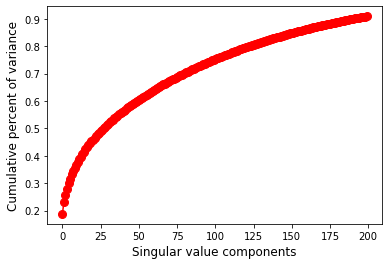

In [61]:
explained = svd.explained_variance_ratio_.cumsum()
plt.plot(explained, '.-', ms = 16, color = 'red')
plt.xlabel('Singular value components', fontsize = 12)
plt.ylabel('Cumulative percent of variance', fontsize = 12)        
plt.show()

# Content/Collaborative and Hybrid cosine similarity

In [83]:
from sklearn.metrics.pairwise import cosine_similarity, linear_kernel

In [133]:
a_1 = np.array(latent_matrix_1_df.loc["Look Who's Talking (1989)"]).reshape(1, -1)
a_2 = np.array(latent_matrix_2_df.loc["Look Who's Talking (1989)"]).reshape(1, -1)

In [134]:
score_1 = cosine_similarity(latent_matrix_1_df, a_1).reshape(-1)
score_2 = cosine_similarity(latent_matrix_2_df, a_2).reshape(-1)

In [135]:
hybrid = ((score_1 + score_2) / 2.0)

In [136]:
dictDf = {'content': score_1, 'collaborative': score_2, 'hybrid': hybrid} 
similar = pd.DataFrame(dictDf, index = latent_matrix_1_df.index)

In [137]:
similar.sort_values('content', ascending = False, inplace = True)
similar[1:].head(11)

,content,collaborative,hybrid
Jack and Sarah (1995),0.929477,0.182365,0.555921
L.A. Story (1991),0.657308,0.296686,0.476997
"Sure Thing, The (1985)",0.654159,0.087722,0.370941
Better Off Dead... (1985),0.651753,0.127293,0.389523
"Truth About Cats & Dogs, The (1996)",0.650967,0.241869,0.446418
Nine Months (1995),0.648773,0.202751,0.425762
Two if by Sea (1996),0.648773,0.018387,0.333580
French Twist (Gazon maudit) (1995),0.648773,0.223720,0.436247
"Fast Food, Fast Women (2000)",0.648773,0.000171,0.324472
Frankie and Johnny (1991),0.648773,0.415827,0.532300


In [138]:
b_1 = np.array(latent_matrix_1_df.loc["Look Who's Talking (1989)"]).reshape(1, -1)
b_2 = np.array(latent_matrix_2_df.loc["Look Who's Talking (1989)"]).reshape(1, -1)

In [139]:
score_1_lin = linear_kernel(latent_matrix_1_df, b_1).reshape(-1)
score_2_lin = linear_kernel(latent_matrix_2_df, b_2).reshape(-1)

In [140]:
hybrid = ((score_1_lin + score_2_lin) / 2.0)

In [141]:
dictDf = {'content': score_1_lin, 'collaborative': score_2_lin, 'hybrid': hybrid} 
similar = pd.DataFrame(dictDf, index = latent_matrix_1_df.index)

In [142]:
similar.sort_values('content', ascending = False, inplace = True)
similar[1:].head(11)

,content,collaborative,hybrid
Two if by Sea (1996),0.353239,0.718903,0.536071
Confessions of a Shopaholic (2009),0.353239,-0.375737,-0.011249
Mannequin (1987),0.353239,30.053113,15.203176
Secret Admirer (1985),0.353239,0.002315,0.177777
"Woman in Red, The (1984)",0.353239,17.578056,8.965647
"Guru, The (2002)",0.353239,0.336439,0.344839
Saving Silverman (Evil Woman) (2001),0.353239,18.342352,9.347795
"Back-up Plan, The (2010)",0.353239,0.108115,0.230677
"Midsummer Night's Sex Comedy, A (1982)",0.353239,23.825425,12.089332
Office Romance (1977),0.353239,-0.037661,0.157789
